## Fast Agent - Build a SQL Agent

<img src="./assets/LC_L1_Top.png" align="left" width="500">

### Environment Setup

Load and check environment variables

In [32]:
from dotenv import load_dotenv
from utils import doublecheck_env

load_dotenv()

# Check and print results
doublecheck_env(".env")

LANGSMITH_API_KEY=****8392
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=****ials
OPENAI_API_KEY=****wEQA


### Setup Database

In [33]:
from langchain_community.utilities import SQLDatabase

sqldb = SQLDatabase.from_uri("sqlite:///Chinook.db")

Define the runtime context to provide the agent and tools with access to the database

In [34]:
from dataclasses import dataclass

# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    condextdb: SQLDatabase

- This demo does not include a filter on LLM generated commands. In production limit the scope of LLM generated commands
- This tool will connect the database
- Note the use of get_runtime to access the graph runtime

### Prepare Tools

In [35]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Exxecute SQLite command and return the results as a string."""

    runtime = get_runtime(RuntimeContext)
    db = runtime.context.condextdb

    try:
        return db.run(query)
    except Exception as e:
        return f"Error executing query: {e}"

### Add system prompt

In [36]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

### Create agent

- Add model
- Add tools
- Add system prompt
- Add runtime context

In [41]:
from langchain.agents import create_agent

agent = create_agent(
    model="ollama:gpt-oss:20b-cloud",
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

Display agent ReAct loop

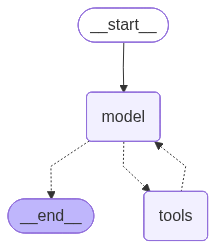

In [42]:
from IPython.display import display, Image

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

### Run queries

- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

In [43]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(condextdb=sqldb),
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (c544aa11-5831-4b77-af65-35902d23c492)
 Call ID: c544aa11-5831-4b77-af65-35902d23c492
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (df884a10-3715-4176-95da-acab2097626f)
 Call ID: df884a10-3715-4176-95da-acab2097626f
  Args:
    query: SELECT 'Album' AS tbl, COUNT(*) AS cnt FROM Album
UNION ALL
SELECT 'Artist', COUNT(*) FROM Artist
UNION 